Find the best hyperparameter (35/40) for RO-R

In [10]:
import geopandas as gpd

# Load the GeoJSON file
file_path = '/data/private/BreizhCrops/experiments/training_results/main/10-baseline/10-baseline_model_accuracies.geojson'
gdf = gpd.read_file(file_path)

# Display the header and first 5 entries
print(gdf.head())


        id CODE_CULTU                   path     meanCLD  sequencelength  \
0  6017304        BTA  csv/frh01/6017304.csv  737.280000              50   
1  6017310        CZH  csv/frh01/6017310.csv  710.327555              50   
2  6017312        PPR  csv/frh01/6017312.csv  696.743646              50   
3  6017313        J5M  csv/frh01/6017313.csv  698.384336              50   
4  6017314        TTH  csv/frh01/6017314.csv  764.057738              50   

   classid                                 classname region          area  \
0        5                             miscellaneous  frh01   1665.638609   
1       10                                  rapeseed  frh01  41233.158559   
2        9                             protein crops  frh01  31913.064203   
3        4  gel (frozen surfaces without production)  frh01   4785.336170   
4        7                             other cereals  frh01  38085.311301   

    perimeter  area_perimeter_ratio  distance_to_closest_city  Field_ID  \
0  18

In [ ]:
import os
import pandas as pd

# Path to your main folder containing datasets
main_path = "/data/private/BreizhCrops/experiments/training_results/main"

# List of dataset IDs from 0 to 10
dataset_ids = range(11)

# Methods to compare, with folder names
methods = [
    {"folder_name": "RO-R-area-35", "csv_name": "RO-R-35"},
    {"folder_name": "RO-R-area-40", "csv_name": "RO-R-40"}
]

# Column names in the CSV file
metrics_column = "Metric"
val_gmean_epoch_column = "val_Highest GMean Epoch"

# Store results
results = []

for dataset_id in dataset_ids:
    gmeans = {}
    print(f"Processing Dataset {dataset_id}...")
    
    for method in methods:
        folder_name = method["folder_name"]
        csv_name = method["csv_name"]
        
        # Construct the dataset-method folder path
        dataset_method_folder = os.path.join(main_path, f"{dataset_id}-{folder_name}")
        
        # Construct the summary statistics folder path
        summary_folder = os.path.join(dataset_method_folder, "summary_statistics")
        
        # Check if the summary folder exists
        if not os.path.isdir(summary_folder):
            print(f"  Summary folder not found: {summary_folder}. Skipping {csv_name}.")
            continue
        
        # Find the summary CSV file by suffix
        summary_csv = None
        for file in os.listdir(summary_folder):
            if file.endswith("summary_statistics.csv"):
                summary_csv = os.path.join(summary_folder, file)
                break
        
        # If summary CSV not found, skip this method
        if not summary_csv:
            print(f"  Summary CSV file not found for method {csv_name} in dataset {dataset_id}. Skipping.")
            continue
        
        # Read the CSV file
        df = pd.read_csv(summary_csv)
        
        # Extract the 'val_Highest GMean Epoch' value
        if val_gmean_epoch_column in df.columns:
            val_highest_gmean_epoch = df[val_gmean_epoch_column].iloc[0]
        else:
            print(f"  Column '{val_gmean_epoch_column}' not found in {summary_csv}. Skipping {csv_name}.")
            continue
        
        # Find the gmean value from the 'metrics' column
        if metrics_column in df.columns:
            gmean_value = df.loc[df[metrics_column] == 'gmean', val_gmean_epoch_column].values[0]
            gmeans[csv_name] = gmean_value
        else:
            print(f"  Column '{metrics_column}' not found in {summary_csv}. Skipping {csv_name}.")
    
    # Print out the gmean values for each method
    for method in methods:
        csv_name = method["csv_name"]
        gmean_value = gmeans.get(csv_name, 'N/A')
        print(f"  {csv_name} gmean = {gmean_value}")
    
    # Determine the best hyperparameter for the dataset
    if gmeans:
        best_method = max(gmeans, key=gmeans.get)
        best_hyperparameter = best_method.split('-')[-1]
        results.append(f"{dataset_id}-{best_hyperparameter}")
    else:
        print(f"  No valid gmean values found for Dataset {dataset_id}.")

# Print the best hyperparameters for each dataset
print("\nBest hyperparameters for each dataset:")
for result in results:
    print(result)


In [146]:
import os
import pandas as pd
import geopandas as gpd
from sklearn.metrics import f1_score, accuracy_score
from imblearn.metrics import geometric_mean_score  # Import for G-Mean calculation

# Paths
main_path = "/data/private/BreizhCrops/experiments/training_results/main"
results_path = "/data/private/BreizhCrops/experiments/training_results/results"
os.makedirs(results_path, exist_ok=True)
output_csv = os.path.join(results_path, "all_results.csv")

# Dataset IDs
dataset_ids = range(1, 11)

# Methods
methods_without_hyperparameters = ['baseline', 'RO', 'WCE']
methods_with_hyperparameters = ['FL', 'DOWCE', 'RO-FL', 'RO-DOWCE']
ro_r_area_method = 'RO-R-area'
ro_r_area_hyperparameters = ['35', '40']

# Initialize results
all_results = []
processed_combinations = set()  # To keep track of processed (dataset_id, method_name) combinations

# Function to process a method folder
def process_method_folder(dataset_id, method_name, method_folder):
    # Skip if this combination has already been processed
    if (dataset_id, method_name) in processed_combinations:
        print(f"    Already processed {method_name} for dataset {dataset_id}. Skipping.")
        return
    else:
        processed_combinations.add((dataset_id, method_name))
        print(f"    Processing {method_name} for dataset {dataset_id}.")

    # Locate the GeoJSON file
    geojson_file = None
    for root, dirs, files in os.walk(method_folder):
        for file in files:
            if file.endswith("model_accuracies.geojson"):
                geojson_file = os.path.join(root, file)
                break
        if geojson_file:
            break

    if not geojson_file:
        print(f"    GeoJSON file not found for method '{method_name}' in dataset {dataset_id}. Skipping.")
        return

    # Read the GeoJSON file
    geo_df = gpd.read_file(geojson_file)

    # Filter the rows where `region` is 'frh04'
    filtered_df = geo_df[geo_df['region'] == 'frh04']

    if filtered_df.empty:
        print(f"    No data found for region 'frh04' in dataset {dataset_id}, method '{method_name}'. Skipping.")
        return

    # Extract class labels dynamically from the data
    class_labels = sorted(filtered_df['True_Label'].unique())

    # Calculate overall metrics
    overall_accuracy = accuracy_score(filtered_df['True_Label'], filtered_df['Predicted_Label'])
    macro_f1 = f1_score(
        filtered_df['True_Label'],
        filtered_df['Predicted_Label'],
        labels=class_labels,
        average='macro',
        zero_division=0
    )
    # Calculate G-Mean
    gmean = geometric_mean_score(filtered_df['True_Label'], filtered_df['Predicted_Label'], labels=class_labels)

    # Split into small and large parcels based on 'area' threshold
    small_parcels = filtered_df[filtered_df['area'] < 6170]
    large_parcels = filtered_df[filtered_df['area'] >= 6170]

    # Check if both groups have data
    if not small_parcels.empty and not large_parcels.empty:
        # Calculate Macro F1 for small parcels
        macro_f1_small = f1_score(
            small_parcels['True_Label'],
            small_parcels['Predicted_Label'],
            labels=class_labels,
            average='macro',
            zero_division=0
        )
        # Calculate Macro F1 for large parcels
        macro_f1_large = f1_score(
            large_parcels['True_Label'],
            large_parcels['Predicted_Label'],
            labels=class_labels,
            average='macro',
            zero_division=0
        )
        # Calculate Macro F1 Difference
        macro_f1_difference = macro_f1_small - macro_f1_large
    else:
        # Handle cases where one group is empty
        macro_f1_small = macro_f1_large = macro_f1_difference = None
        print(f"    One of the parcel groups is empty in dataset {dataset_id}, method '{method_name}'.")

    # Store the results
    result_entry = {
        'Dataset_ID': dataset_id,
        'Method': method_name,
        'Overall_Accuracy': overall_accuracy,
        'Macro_F1': macro_f1,
        'GMean': gmean,  # Store G-Mean
        'Macro_F1_Small_Parcels': macro_f1_small,
        'Macro_F1_Large_Parcels': macro_f1_large,
        'Macro_F1_Difference': macro_f1_difference
    }
    all_results.append(result_entry)
    print(f"    Added result: {result_entry}")

    print(f"    {method_name} - Overall Accuracy: {overall_accuracy:.4f}, Macro F1: {macro_f1:.4f}, G-Mean: {gmean:.4f}")
    if macro_f1_difference is not None:
        print(f"    Macro F1 Small Parcels: {macro_f1_small:.4f}, Macro F1 Large Parcels: {macro_f1_large:.4f}")
        print(f"    Macro F1 Difference: {macro_f1_difference:.4f}")

# The rest of the code remains unchanged (processing datasets and saving results)


# Iterate over datasets
for dataset_id in dataset_ids:
    print(f"\nProcessing Dataset {dataset_id}...")

    # -----------------------------
    # Step 1: Process methods without hyperparameters
    # -----------------------------
    for method in methods_without_hyperparameters:
        print(f"  Processing Method: {method}...")

        # Find folder for this dataset and method
        method_folder = None
        for folder in os.listdir(main_path):
            if folder == f"{dataset_id}-{method}" or folder == f"{dataset_id}-{method}-best":
                method_folder = os.path.join(main_path, folder)
                break

        if not method_folder:
            print(f"    Method folder not found for '{method}' in dataset {dataset_id}. Skipping.")
            continue

        # Extract method name
        folder_name = os.path.basename(method_folder)
        method_name_parts = folder_name.split('-')[1:]
        if 'best' in method_name_parts:
            method_name_parts.remove('best')
        method_name = '-'.join(method_name_parts)

        # Process method_folder and extract metrics
        process_method_folder(dataset_id, method_name, method_folder)

     # -----------------------------
    # Step 2: Process methods with hyperparameters
    # -----------------------------
    for method in methods_with_hyperparameters:
        print(f"  Processing Method with Hyperparameters: {method}...")

        # Find all folders for this dataset and method
        method_folders = []
        for folder in os.listdir(main_path):
            if folder.startswith(f"{dataset_id}-{method}-"):
                method_folders.append(folder)

        # Debugging: Print all found folders for the current method
        print(f"    Found folders for '{method}' in dataset {dataset_id}: {method_folders}")

        if not method_folders:
            print(f"    No folders found for method '{method}' in dataset {dataset_id}. Skipping.")
            continue

        # Process each unique hyperparameter value
        processed_hyperparams = set()
        for folder_name in method_folders:
            parts = folder_name.split('-')
            if len(parts) < 3:
                continue  # Not enough parts to extract hyperparameter
            hyperparameter = parts[2]

            # Construct method_name
            method_name_parts = parts[1:]
            if 'best' in method_name_parts:
                method_name_parts.remove('best')
            method_name = '-'.join(method_name_parts)

            # Skip if we've already processed this method-hyperparameter combination
            method_hyperparam_key = (method, hyperparameter)
            if method_hyperparam_key in processed_hyperparams:
                continue
            processed_hyperparams.add(method_hyperparam_key)

            method_folder = os.path.join(main_path, folder_name)

            # Debugging: Confirm the folder being processed
            print(f"    Processing folder: {method_folder} for method: {method_name}")

            # Process method_folder and extract metrics
            process_method_folder(dataset_id, method_name, method_folder)


    # -----------------------------
    # Step 3: Process RO-R-area method
    # -----------------------------
    for hyperparameter in ro_r_area_hyperparameters:
        print(f"  Processing Method: {ro_r_area_method}-{hyperparameter}...")

        # Build folder name with '-best' suffix
        folder_name = f"{dataset_id}-{ro_r_area_method}-{hyperparameter}-best"
        method_folder = os.path.join(main_path, folder_name)

        if not os.path.exists(method_folder):
            print(f"    Folder not found: {folder_name}. Skipping.")
            continue

        method_name = f"{ro_r_area_method}-{hyperparameter}"

        # Process method_folder and extract metrics
        process_method_folder(dataset_id, method_name, method_folder)

# After processing all methods and datasets, save results to CSV
results_df = pd.DataFrame(all_results)

# Print all results before saving to CSV
print("\nAll results collected:")
print(results_df)

results_df.to_csv(output_csv, index=False)

print(f"\nResults saved to: {output_csv}")



Processing Dataset 1...
  Processing Method: baseline...
    Processing baseline for dataset 1.
    Added result: {'Dataset_ID': 1, 'Method': 'baseline', 'Overall_Accuracy': 0.730183400683867, 'Macro_F1': 0.7147010885745845, 'GMean': 0.7492462638822964, 'Macro_F1_Small_Parcels': 0.5268361124670964, 'Macro_F1_Large_Parcels': 0.7545452050629737, 'Macro_F1_Difference': -0.22770909259587735}
    baseline - Overall Accuracy: 0.7302, Macro F1: 0.7147, G-Mean: 0.7492
    Macro F1 Small Parcels: 0.5268, Macro F1 Large Parcels: 0.7545
    Macro F1 Difference: -0.2277
  Processing Method: RO...
    Processing RO for dataset 1.
    Added result: {'Dataset_ID': 1, 'Method': 'RO', 'Overall_Accuracy': 0.7706973370635167, 'Macro_F1': 0.7697424857082118, 'GMean': 0.7890779435884572, 'Macro_F1_Small_Parcels': 0.6016597299445552, 'Macro_F1_Large_Parcels': 0.8005452653057861, 'Macro_F1_Difference': -0.19888553536123088}
    RO - Overall Accuracy: 0.7707, Macro F1: 0.7697, G-Mean: 0.7891
    Macro F1 Sma

# Classwise result processing for specified dataset

In [13]:
import os
import pandas as pd
import geopandas as gpd
from sklearn.metrics import f1_score

# Paths
main_path = "/data/private/BreizhCrops/experiments/training_results/main"
results_path = "/data/private/BreizhCrops/experiments/training_results/results"
os.makedirs(results_path, exist_ok=True)
output_csv = os.path.join(results_path, "dataset_10_full_results.csv")

# Target dataset ID
target_dataset_id = 10

# Methods
methods_without_hyperparameters = ['baseline', 'RO', 'WCE']
methods_with_hyperparameters = ['FL', 'DOWCE', 'RO-FL', 'RO-DOWCE']
ro_r_area_method = 'RO-R-area'
ro_r_area_hyperparameters = ['35', '40']

# Initialize results
all_results = []

# Function to process a method folder
def process_method_folder(dataset_id, method_name, method_folder):
    print(f"    Processing {method_name} for dataset {dataset_id}.")

    # Locate the GeoJSON file
    geojson_file = None
    for root, dirs, files in os.walk(method_folder):
        for file in files:
            if file.endswith("model_accuracies.geojson"):
                geojson_file = os.path.join(root, file)
                break
        if geojson_file:
            break

    if not geojson_file:
        print(f"    GeoJSON file not found for method '{method_name}' in dataset {dataset_id}. Skipping.")
        return

    # Read the GeoJSON file
    geo_df = gpd.read_file(geojson_file)

    # Filter the rows where `region` is 'frh04'
    filtered_df = geo_df[geo_df['region'] == 'frh04']

    if filtered_df.empty:
        print(f"    No data found for region 'frh04' in dataset {dataset_id}, method '{method_name}'. Skipping.")
        return

    # Extract class labels dynamically from the data
    class_labels = sorted(filtered_df['True_Label'].unique())

    # Calculate overall macro F1
    macro_f1 = f1_score(
        filtered_df['True_Label'],
        filtered_df['Predicted_Label'],
        labels=class_labels,
        average='macro',
        zero_division=0
    )

    # Calculate per-class F1 scores
    per_class_f1 = f1_score(
        filtered_df['True_Label'],
        filtered_df['Predicted_Label'],
        labels=class_labels,
        average=None,
        zero_division=0
    )

    # Split into small and large parcels based on 'area' threshold
    small_parcels = filtered_df[filtered_df['area'] < 6170]
    large_parcels = filtered_df[filtered_df['area'] >= 6170]

    # Check if both groups have data
    if not small_parcels.empty and not large_parcels.empty:
        # Calculate Macro F1 for small parcels
        macro_f1_small = f1_score(
            small_parcels['True_Label'],
            small_parcels['Predicted_Label'],
            labels=class_labels,
            average='macro',
            zero_division=0
        )
        # Calculate Macro F1 for large parcels
        macro_f1_large = f1_score(
            large_parcels['True_Label'],
            large_parcels['Predicted_Label'],
            labels=class_labels,
            average='macro',
            zero_division=0
        )
        # Calculate Macro F1 Difference
        macro_f1_difference = macro_f1_small - macro_f1_large

        # Calculate per-class F1 scores for small and large parcels
        per_class_f1_small = f1_score(
            small_parcels['True_Label'],
            small_parcels['Predicted_Label'],
            labels=class_labels,
            average=None,
            zero_division=0
        )
        per_class_f1_large = f1_score(
            large_parcels['True_Label'],
            large_parcels['Predicted_Label'],
            labels=class_labels,
            average=None,
            zero_division=0
        )
        # Calculate per-class F1 differences
        per_class_f1_difference = per_class_f1_small - per_class_f1_large
    else:
        # Handle cases where one group is empty
        macro_f1_small = macro_f1_large = macro_f1_difference = None
        per_class_f1_small = per_class_f1_large = per_class_f1_difference = [None] * len(class_labels)
        print(f"    One of the parcel groups is empty in dataset {dataset_id}, method '{method_name}'.")

    # Store the results
    result_entry = {
        'Dataset_ID': dataset_id,
        'Method': method_name,
        'Macro_F1': macro_f1,
        'Macro_F1_Small_Parcels': macro_f1_small,
        'Macro_F1_Large_Parcels': macro_f1_large,
        'Macro_F1_Difference': macro_f1_difference
    }

    # Append per-class F1 and differences
    for i, label in enumerate(class_labels):
        result_entry[f'F1_Class_{label}'] = per_class_f1[i]
        result_entry[f'F1_Small_Class_{label}'] = per_class_f1_small[i]
        result_entry[f'F1_Large_Class_{label}'] = per_class_f1_large[i]
        result_entry[f'F1_Diff_Class_{label}'] = per_class_f1_difference[i]

    all_results.append(result_entry)
    print(f"    Added result: {result_entry}")

# Process only dataset 10
dataset_id = target_dataset_id
print(f"\nProcessing Dataset {dataset_id}...")

# -----------------------------
# Step 1: Process methods without hyperparameters
# -----------------------------
for method in methods_without_hyperparameters:
    print(f"  Processing Method: {method}...")

    # Find folder for this dataset and method
    method_folder = None
    for folder in os.listdir(main_path):
        if folder == f"{dataset_id}-{method}" or folder == f"{dataset_id}-{method}-best":
            method_folder = os.path.join(main_path, folder)
            break

    if not method_folder:
        print(f"    Method folder not found for '{method}' in dataset {dataset_id}. Skipping.")
        continue

    # Extract method name
    folder_name = os.path.basename(method_folder)
    method_name_parts = folder_name.split('-')[1:]
    if 'best' in method_name_parts:
        method_name_parts.remove('best')
    method_name = '-'.join(method_name_parts)

    # Process method_folder and extract metrics
    process_method_folder(dataset_id, method_name, method_folder)

# -----------------------------
# Step 2: Process methods with hyperparameters
# -----------------------------
for method in methods_with_hyperparameters:
    print(f"  Processing Method with Hyperparameters: {method}...")

    # Find all folders for this dataset and method
    method_folders = []
    for folder in os.listdir(main_path):
        if folder.startswith(f"{dataset_id}-{method}-"):
            method_folders.append(folder)

    if not method_folders:
        print(f"    No folders found for method '{method}' in dataset {dataset_id}. Skipping.")
        continue

    # Process each unique hyperparameter value
    for folder_name in method_folders:
        method_folder = os.path.join(main_path, folder_name)
        method_name_parts = folder_name.split('-')[1:]
        method_name = '-'.join(method_name_parts)

        # Process method_folder and extract metrics
        process_method_folder(dataset_id, method_name, method_folder)

# -----------------------------
# Step 3: Process RO-R-area method
# -----------------------------
for hyperparameter in ro_r_area_hyperparameters:
    print(f"  Processing Method: {ro_r_area_method}-{hyperparameter}...")

    # Build folder name with '-best' suffix
    folder_name = f"{dataset_id}-{ro_r_area_method}-{hyperparameter}-best"
    method_folder = os.path.join(main_path, folder_name)

    if not os.path.exists(method_folder):
        print(f"    Folder not found: {folder_name}. Skipping.")
        continue

    method_name = f"{ro_r_area_method}-{hyperparameter}"

    # Process method_folder and extract metrics
    process_method_folder(dataset_id, method_name, method_folder)

# Save results to CSV
results_df = pd.DataFrame(all_results)

# Print all results before saving to CSV
print("\nAll results collected for Dataset 10:")
print(results_df)

results_df.to_csv(output_csv, index=False)

print(f"\nResults saved to: {output_csv}")



Processing Dataset 10...
  Processing Method: baseline...
    Processing baseline for dataset 10.
    Added result: {'Dataset_ID': 10, 'Method': 'baseline', 'Macro_F1': 0.4118056261523504, 'Macro_F1_Small_Parcels': 0.28465048164975365, 'Macro_F1_Large_Parcels': 0.4224133224922872, 'Macro_F1_Difference': -0.13776284084253354, 'F1_Class_0': 0.7842605156037991, 'F1_Small_Class_0': 0.4916201117318436, 'F1_Large_Class_0': 0.8100393700787402, 'F1_Diff_Class_0': -0.31841925834689655, 'F1_Class_1': 0.09620253164556962, 'F1_Small_Class_1': 0.03592814371257485, 'F1_Large_Class_1': 0.09956565319077848, 'F1_Diff_Class_1': -0.06363750947820362, 'F1_Class_2': 0.8194966734162569, 'F1_Small_Class_2': 0.45272969374167776, 'F1_Large_Class_2': 0.8641895180918384, 'F1_Diff_Class_2': -0.41145982435016065, 'F1_Class_3': 0.4531317494600432, 'F1_Small_Class_3': 0.18532818532818532, 'F1_Large_Class_3': 0.4868677042801557, 'F1_Diff_Class_3': -0.3015395189519704, 'F1_Class_4': 0.1901588928754485, 'F1_Small_Clas

# Clean results from suffixes

In [147]:
import pandas as pd

# Path to original results CSV file
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/all_results.csv'

# Read the results CSV file
df = pd.read_csv(results_csv)

# Prefix mapping in the order of priority to ensure correct replacements
prefix_mapping = [
    ('RO-DOWCE', 'RO-DOWCE'),
    ('RO-FL', 'RO-FL'),
    ('DOWCE', 'DOWCE'),
    ('FL', 'FL'),
    ('RO-WCE', 'RO-WCE'),
    ('WCE', 'WCE'),
    ('RO-R', 'RO-R'),
    ('RO', 'RO'),
    ('baseline', 'baseline')
]

# Function to standardize method names based on the prefix mapping
def standardize_method(method_name):
    for prefix, standardized_name in prefix_mapping:
        if method_name.startswith(prefix):
            return standardized_name
    return method_name

# Apply the standardization to the Method column
df['Method'] = df['Method'].apply(standardize_method)

# Save the cleaned CSV file
cleaned_csv_path = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned results saved to: {cleaned_csv_path}")


Cleaned results saved to: /data/private/BreizhCrops/experiments/training_results/results/results.csv


# Critical distance plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of datasets (N): 10
Number of methods (k): 8

Analyzing Metric: Macro_F1
Effective number of datasets after dropping NaNs: 10
Friedman test statistic: 37.6667, p-value: 0.0000035059
Ranks for each dataset (rows) across methods (columns):
[[6 2 1 3 4 5 7 8]
 [6 8 7 2 5 1 3 4]
 [6 7 5 1 3 4 2 8]
 [2 4 3 1 6 5 7 8]
 [8 4 1 2 5 3 6 7]
 [6 7 2 1 3 4 5 8]
 [7 5 4 1 3 2 6 8]
 [5 7 4 3 2 1 6 8]
 [4 2 3 1 5 6 7 8]
 [6 7 5 1 2 3 4 8]]
Average ranks:
  DOWCE: 5.6000
  FL: 5.3000
  RO: 3.5000
  RO-DOWCE: 1.6000
  RO-FL: 3.8000
  RO-R: 3.4000
  WCE: 5.3000
  baseline: 7.5000
Critical Difference (CD): 2.9467

Pseudo p-value matrix:
             DOWCE        FL        RO  RO-DOWCE     RO-FL      RO-R  \
DOWCE     1.000000  0.900000  0.900000  0.000001  0.900000  0.900000   
FL        0.900000  1.000000  0.900000  0.000001  0.900000  0.900000   
RO        0.900000  0.900000  1.000000  0.900000  0.900000  0.900000   
RO-DOWCE  0.000001  0.000001  0.900000  1.000000  0.900000  0.900000   
RO-FL  

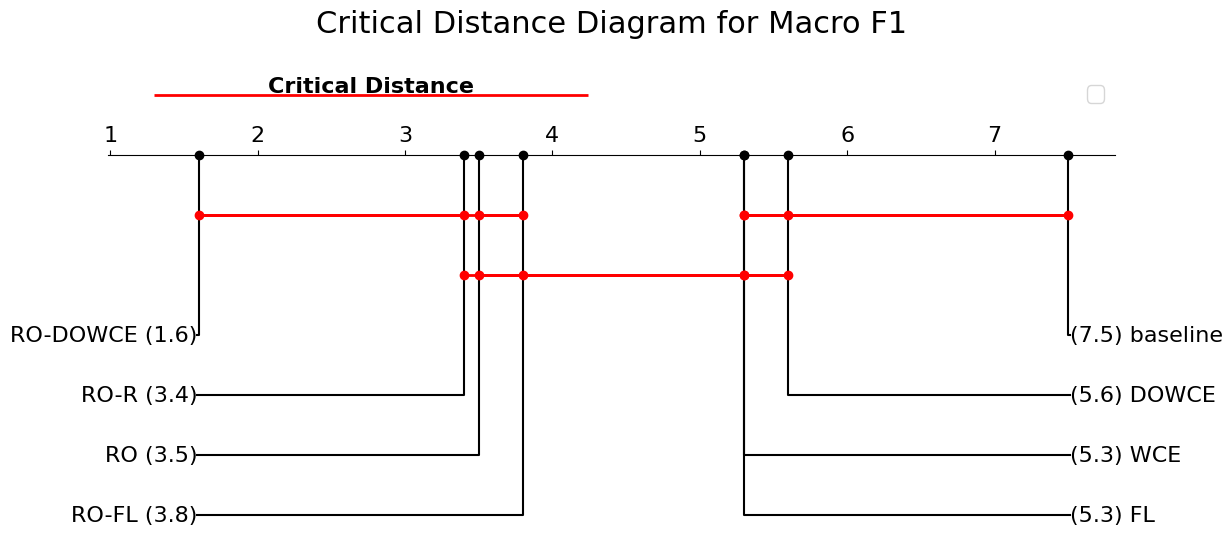

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Analyzing Metric: Macro_F1_Difference
Effective number of datasets after dropping NaNs: 10
Friedman test statistic: 15.2000, p-value: 0.0335194666
Ranks for each dataset (rows) across methods (columns):
[[1 2 3 7 6 4 5 8]
 [2 6 7 4 1 3 8 5]
 [3 2 8 7 4 1 6 5]
 [4 2 8 6 3 1 5 7]
 [2 6 4 3 5 1 7 8]
 [1 7 4 2 3 8 5 6]
 [1 4 6 2 3 8 5 7]
 [1 2 6 8 5 7 4 3]
 [2 3 8 4 6 7 1 5]
 [7 3 5 4 2 8 6 1]]
Average ranks:
  DOWCE: 2.4000
  FL: 3.7000
  RO: 5.9000
  RO-DOWCE: 4.7000
  RO-FL: 3.8000
  RO-R: 4.8000
  WCE: 5.2000
  baseline: 5.5000
Critical Difference (CD): 2.9467

Pseudo p-value matrix:
             DOWCE   FL        RO  RO-DOWCE  RO-FL  RO-R  WCE  baseline
DOWCE     1.000000  0.9  0.000001       0.9    0.9   0.9  0.9  0.000001
FL        0.900000  1.0  0.900000       0.9    0.9   0.9  0.9  0.900000
RO        0.000001  0.9  1.000000       0.9    0.9   0.9  0.9  0.900000
RO-DOWCE  0.900000  0.9  0.900000       1.0    0.9   0.9  0.9  0.900000
RO-FL     0.900000  0.9  0.900000       0.9    1

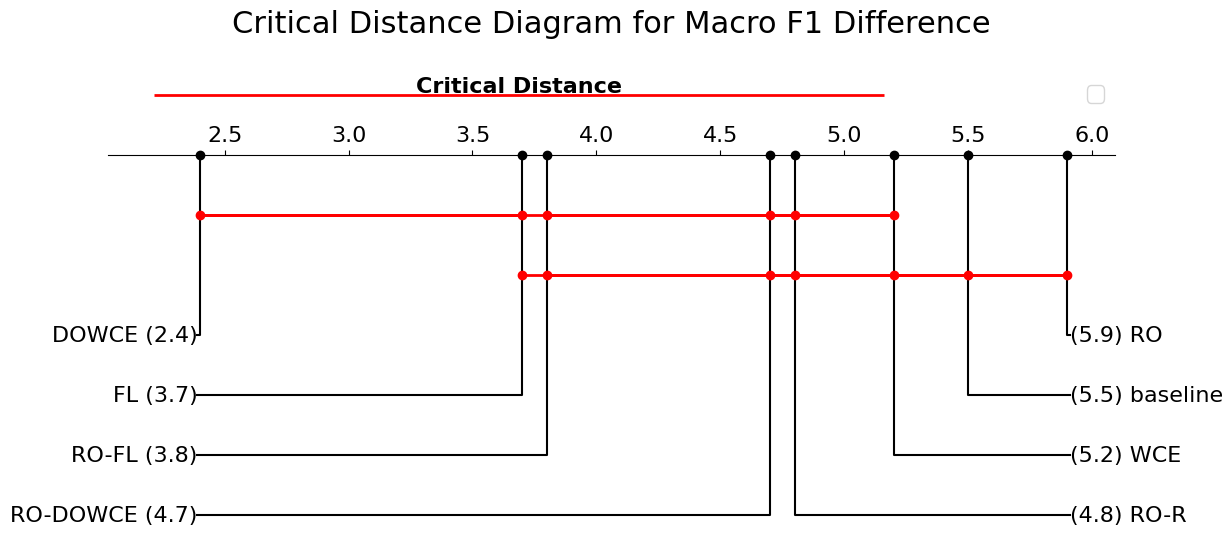

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Analyzing Metric: Macro_F1_Small_Parcels
Effective number of datasets after dropping NaNs: 10
Friedman test statistic: 31.2667, p-value: 0.0000555126
Ranks for each dataset (rows) across methods (columns):
[[6 2 1 3 5 4 7 8]
 [5 8 7 3 4 1 6 2]
 [5 6 7 2 1 4 3 8]
 [1 3 6 2 5 4 7 8]
 [7 5 1 3 4 2 6 8]
 [4 7 3 1 2 5 6 8]
 [7 3 5 1 2 4 6 8]
 [5 6 4 3 2 1 7 8]
 [3 2 5 1 6 7 4 8]
 [6 7 3 1 2 4 5 8]]
Average ranks:
  DOWCE: 4.9000
  FL: 4.9000
  RO: 4.2000
  RO-DOWCE: 2.0000
  RO-FL: 3.3000
  RO-R: 3.6000
  WCE: 5.7000
  baseline: 7.4000
Critical Difference (CD): 2.9467

Pseudo p-value matrix:
          DOWCE   FL        RO  RO-DOWCE     RO-FL      RO-R       WCE  \
DOWCE       1.0  0.9  0.900000  0.900000  0.900000  0.900000  0.900000   
FL          0.9  1.0  0.900000  0.900000  0.900000  0.900000  0.900000   
RO          0.9  0.9  1.000000  0.900000  0.900000  0.900000  0.900000   
RO-DOWCE    0.9  0.9  0.900000  1.000000  0.900000  0.900000  0.000001   
RO-FL       0.9  0.9  0.900000  0.9

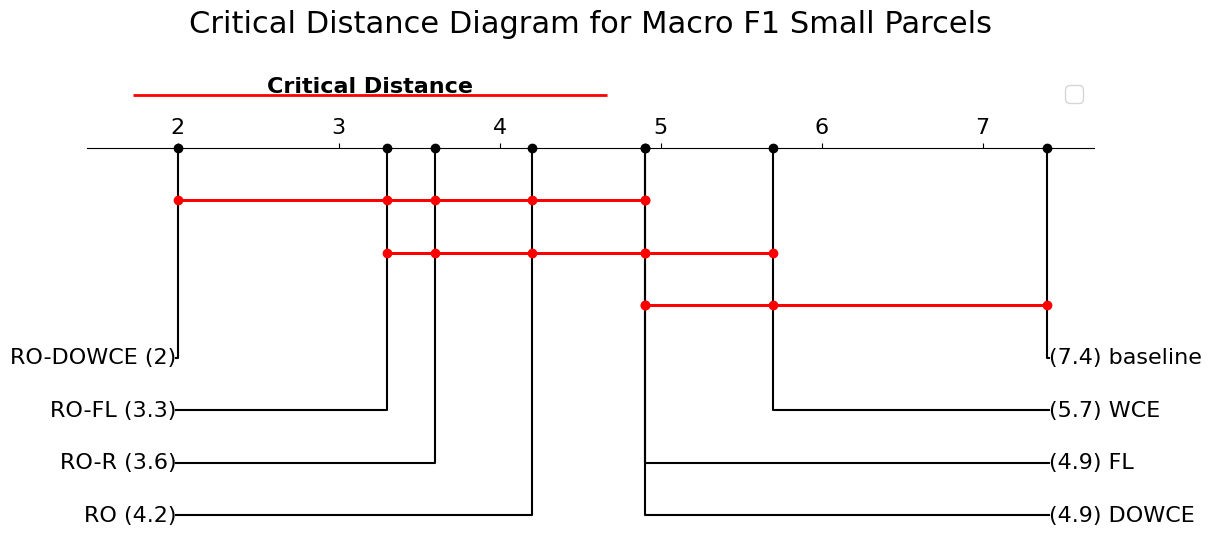

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
from statsmodels.stats.libqsturng import qsturng
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import os

plt.rcParams.update({'font.size': 16})  # Adjust this value to your preference

# Read the cleaned results CSV file
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Exclude the separate Macro F1 for large and small parcels
metrics = ['Macro_F1', 'Macro_F1_Difference', 'Macro_F1_Small_Parcels']

# List of unique standardized methods
methods = df['Method'].unique()

# Number of datasets and methods
N = 10  # Number of datasets
k = len(methods)  # Number of unique standardized methods

print(f"Number of datasets (N): {N}")
print(f"Number of methods (k): {k}")

# Initialize a dictionary to store average ranks for each metric
average_ranks = {}

plots_directory = '/data/private/BreizhCrops/experiments/training_results/results/CD_plots'


for metric in metrics:
    print(f"\nAnalyzing Metric: {metric}")

    # Pivot the dataframe to have standardized methods as columns and datasets as rows
    pivot_df = df.pivot_table(values=metric, index='Dataset_ID', columns='Method')

    # Drop datasets with NaN values for any method
    pivot_df = pivot_df.dropna(axis=0, how='any')

    # Reindex columns to match the available methods after dropping NaNs
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

    # Get the values as a numpy array
    data = pivot_df.values

    # Update N in case any datasets were dropped
    N_effective = data.shape[0]
    print(f"Effective number of datasets after dropping NaNs: {N_effective}")

    # Perform Friedman test
    stat, p = friedmanchisquare(*[data[:, i] for i in range(data.shape[1])])
    print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.10f}")

    # Calculate ranks using rankdata (averaging in case of ties)
    ranks = np.argsort(np.argsort(-data, axis=1), axis=1) + 1  # Higher values get lower ranks
    print(f"Ranks for each dataset (rows) across methods (columns):\n{ranks}")

    average_rank = np.mean(ranks, axis=0)
    method_names = list(pivot_df.columns)
    average_ranks[metric] = dict(zip(method_names, average_rank))

    print("Average ranks:")
    for method, rank in average_ranks[metric].items():
        print(f"  {method}: {rank:.4f}")

    # Calculate the Critical Difference (CD)
    q_alpha = 2.690  # 2.780 for alpha=0.1 , 2.690 for alpha= 0.05
    CD = q_alpha * np.sqrt(k * (k + 1) / (6 * N_effective))
    print(f"Critical Difference (CD): {CD:.4f}")

    # Initialize pseudo p-value matrix
    pseudo_pvals_matrix = pd.DataFrame(1.0, index=method_names, columns=method_names)

    # Fill in pseudo p-value matrix based on rank differences
    for i, method1 in enumerate(method_names):
        for j, method2 in enumerate(method_names):
            if i != j:
                rank_diff = abs(average_ranks[metric][method1] - average_ranks[metric][method2])
                # Assign pseudo p-value based on rank difference
                if rank_diff < CD:
                    pseudo_pvals_matrix.loc[method1, method2] = 0.9  # Not significantly different
                else:
                    pseudo_pvals_matrix.loc[method1, method2] = 0.000001  # Significantly different

    # Print the final pseudo p-value matrix
    print("\nPseudo p-value matrix:")
    print(pseudo_pvals_matrix)

    # Plot the Critical Difference diagram
    fig, ax = plt.subplots(figsize=(13, 6))
    title_metric = metric.replace('_', ' ')
    ax.set_title(f'Critical Distance Diagram for {title_metric}', fontsize=22, pad=30)
    sp.critical_difference_diagram(
        ranks=average_ranks[metric],  # dict of method names and their average ranks
        sig_matrix=pseudo_pvals_matrix,  # use the pseudo p-value matrix
        label_fmt_left='{label} ({rank:.2g})',
        label_fmt_right='({rank:.2g}) {label}',
        ax=ax,
        crossbar_props={'color': 'red', 'marker': 'o'},
        elbow_props={'color': 'black'},     # Ensure elbows are black
        marker_props={'color': 'black'},    # Ensure markers are black
        text_h_margin=0.01                  # Space between text and lines
    )

    # Add CD line to the plot
    # Get the limits of the plot
    rank_min, rank_max = ax.get_xlim()

    # Set a new y position for the CD line (e.g., slightly above the current position)
    cd_y_position = 1.0  # Adjust this value as necessary to control the height

    # Add CD line to the plot
    ax.hlines(y=cd_y_position, xmin=rank_min, xmax=rank_min + CD, color='red', linewidth=2)

    # Add a label for the CD line as a bold black text
    ax.text(
        x=(rank_min + rank_min + CD) / 2,  # Center the text horizontally over the CD line
        y=cd_y_position + 0.05,  # Position the text slightly above the line
        s='Critical Distance',  # Text label
        color='black',  # Text color
        fontsize=16,  # Font size
        fontweight='bold',  # Bold text
        ha='center',  # Center-align the text horizontally
    )
    
    plt.legend()
    plt.show()
    '''
    # Save the plot as SVG
    plot_filename = os.path.join(plots_directory, f"{metric}_CD_plot.svg")
    plt.savefig(plot_filename, format='svg')

    plt.close(fig)
    print(f"Saved {metric} plot as SVG to {plot_filename}")
    '''

# Box plots

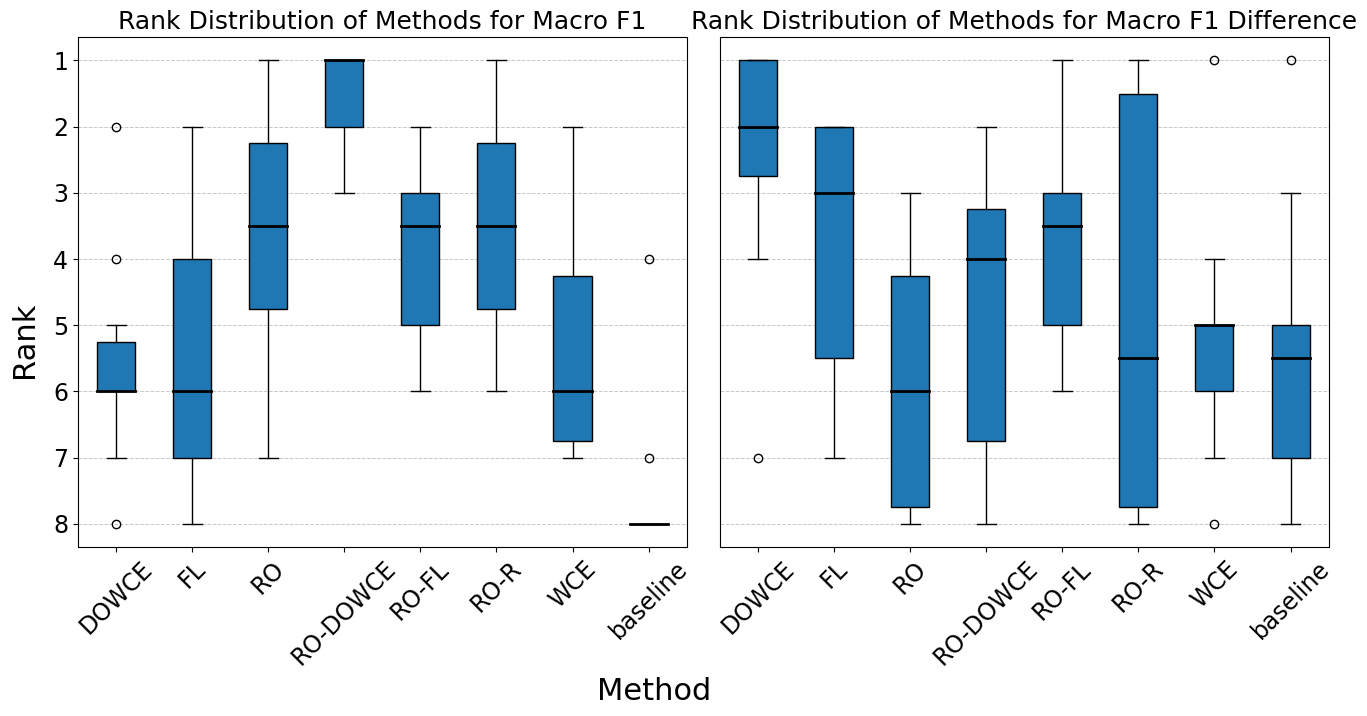

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the cleaned results CSV file
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Exclude the separate Macro F1 for large and small parcels
metrics = ['Macro_F1', 'Macro_F1_Difference']

# List of unique standardized methods
methods = df['Method'].unique()

# Initialize a dictionary to store ranks for each metric
rank_data = {}

# Create a figure with subplots in one row, make the figure longer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7.5))
plt.subplots_adjust(wspace=0.05)  # Reduce the space between subplots for connection effect

for i, metric in enumerate(metrics):
    # Pivot the dataframe to have standardized methods as columns and datasets as rows
    pivot_df = df.pivot_table(values=metric, index='Dataset_ID', columns='Method')

    # Drop datasets with NaN values for any method
    pivot_df = pivot_df.dropna(axis=0, how='any')

    # Calculate ranks for each dataset (lower is better)
    ranks = pivot_df.rank(axis=1, method='average', ascending=False)
    
    # Store rank data for boxplot
    rank_data[metric] = ranks

    # Create boxplot for each metric
    box = axes[i].boxplot(ranks.values, labels=ranks.columns, patch_artist=True,
                          medianprops=dict(color='black', linewidth=2))  # Bold black line for median
    
    # Add horizontal grid
    axes[i].yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    title_metric = metric.replace('_', ' ')
    axes[i].set_title(f'Rank Distribution of Methods for {title_metric}', fontsize=20)
    axes[i].tick_params(axis='x', rotation=45, labelsize=17)
    axes[i].tick_params(axis='y', labelsize=17)
    axes[i].invert_yaxis()  # Invert y-axis to have lower ranks (better) at the top
    axes[i].set_yticks(np.arange(1, 9))  # Set y-ticks from 1 to 8

# Remove y-ticks and y-labels from the second subplot
axes[1].tick_params(axis='y', left=False, labelleft=False)

# Add a common x-label for both plots
fig.text(0.5, 0.02, 'Method', ha='center', fontsize=22)
fig.text(0.04, 0.5, 'Rank', va='center', rotation='vertical', fontsize=22)

# Save the plot as an SVG file
svg_path = '/data/private/BreizhCrops/experiments/training_results/results/box_plots/rank_distribution.svg'
plt.tight_layout(rect=[0.06, 0.04, 1, 0.96])  # Adjust layout to fit labels properly
plt.savefig(svg_path, format='svg')
plt.show()


## Calculate gains 

In [23]:
import pandas as pd
import os

# Read the cleaned results CSV file
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# List of metrics to calculate the gain for, including small and large parcel metrics
metrics = ['Overall_Accuracy', 'Macro_F1', 'Macro_F1_Difference', 'GMean', 'Macro_F1_Small_Parcels', 'Macro_F1_Large_Parcels']

# Initialize a DataFrame to store the gain data
gain_df = df.copy()

# Calculate gain for each metric
for metric in metrics:
    # Extract baseline values for each dataset
    baseline_values = df[df['Method'] == 'baseline'][['Dataset_ID', metric]].set_index('Dataset_ID')
    baseline_values.columns = [f'{metric}_baseline']  # Rename the column to avoid conflicts

    # Merge baseline values with the full DataFrame
    gain_df = gain_df.set_index('Dataset_ID').join(baseline_values, on='Dataset_ID').reset_index()

    if metric == 'Macro_F1_Difference':
        # For Macro_F1_Difference, use absolute values to reflect improvement correctly
        gain_df[f'{metric}_gain'] = abs(gain_df[f'{metric}_baseline']) - abs(gain_df[metric])
    else:
        # For all other metrics, use the standard calculation
        gain_df[f'{metric}_gain'] = gain_df[metric] - gain_df[f'{metric}_baseline']

# Drop the baseline rows as their gain is always 0
gain_df = gain_df[gain_df['Method'] != 'baseline']

# Select relevant columns to save
columns_to_save = ['Dataset_ID', 'Method'] + [f'{metric}_gain' for metric in metrics]

# Create the output CSV directory if it doesn't exist
output_directory = '/data/private/BreizhCrops/experiments/training_results/results'
os.makedirs(output_directory, exist_ok=True)

# Save the result to a new CSV
output_csv_path = os.path.join(output_directory, 'results_with_gains.csv')
gain_df[columns_to_save].to_csv(output_csv_path, index=False)

print(f"Gain CSV created and saved to: {output_csv_path}")


Gain CSV created and saved to: /data/private/BreizhCrops/experiments/training_results/results/results_with_gains.csv


Methods: ['RO' 'WCE' 'FL' 'DOWCE' 'RO-FL' 'RO-DOWCE' 'RO-R']


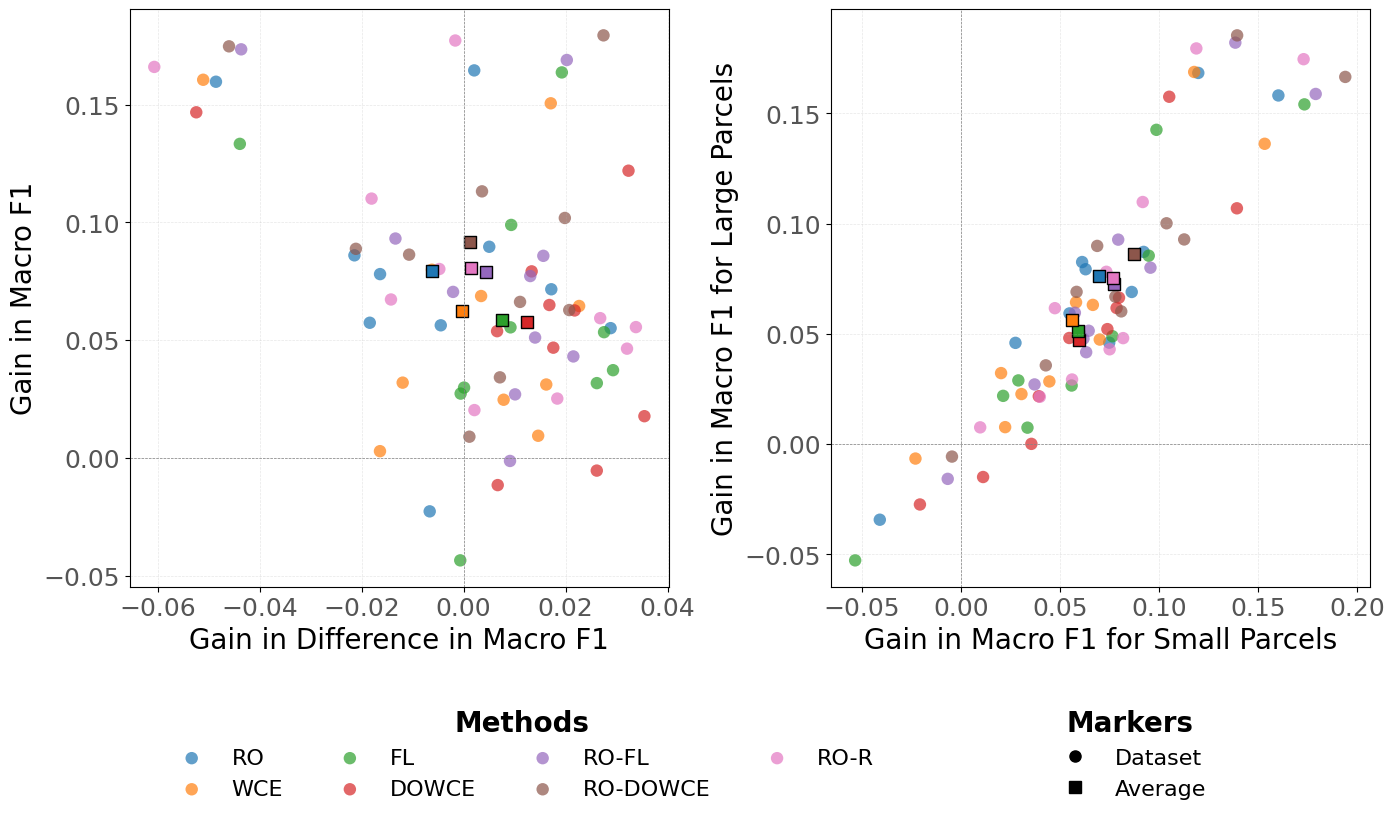

Saved combined scatter plot to /data/private/BreizhCrops/experiments/training_results/results/scatter_plots/Combined_Gain_Plots_with_Small_Large_Parcels.svg


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the directory for saving plots
scatter_plots_directory = '/data/private/BreizhCrops/experiments/training_results/results/scatter_plots'
os.makedirs(scatter_plots_directory, exist_ok=True)

# Read the CSV file with gains already calculated
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results_with_gains.csv'
df = pd.read_csv(results_csv)

# List of unique standardized methods excluding baseline
methods = df['Method'].unique()
print(f"Methods: {methods}")

# Define color palette for methods
methods_palette = sns.color_palette('tab10', len(methods))
methods_colors = {method: methods_palette[i] for i, method in enumerate(methods)}

# Function to create scatter plot for gain
def create_scatter_plot(ax, df, x_metric_gain, y_metric_gain, xlabel, ylabel):
    # Plot individual dataset-method combinations (transparent circles)
    for method in methods:
        subset = df[df['Method'] == method]
        ax.scatter(subset[x_metric_gain], subset[y_metric_gain], label=method, 
                   c=[methods_colors[method]], edgecolor='none', s=80, alpha=0.7, marker='o')

    # Plot averages across datasets for each method (solid squares)
    avg_data = df.groupby('Method')[[x_metric_gain, y_metric_gain]].mean().reset_index()
    for _, row in avg_data.iterrows():
        ax.scatter(row[x_metric_gain], row[y_metric_gain], 
                   c=[methods_colors[row['Method']]], edgecolor='k', s=80, alpha=1.0, marker='s', linewidth=1)
    ax.tick_params(axis='both', which='major', labelcolor='#555555', labelsize=18)
    ax.set_xlabel(f'Gain in {xlabel}', fontsize=20)
    ax.set_ylabel(f'Gain in {ylabel}', fontsize=20)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.3)  # Add transparent grid lines
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Create figure and axes for subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 7.5))  # Adjust size for 2 subplots

plt.subplots_adjust(wspace=0.3)

# Create second scatter plot for "Gain in Macro F1 Difference vs Gain in Macro F1"
create_scatter_plot(axs[0], df, 'Macro_F1_Difference_gain', 'Macro_F1_gain', 'Difference in Macro F1', 'Macro F1')

# Create third scatter plot for "Gain in Macro F1 Large Parcels vs Gain in Macro F1 Small Parcels"
create_scatter_plot(axs[1], df, 'Macro_F1_Small_Parcels_gain', 'Macro_F1_Large_Parcels_gain', 'Macro F1 for Small Parcels', 'Macro F1 for Large Parcels')

# Create a common legend for methods (no transparency) at the bottom center
handles_methods, labels_methods = axs[0].get_legend_handles_labels()
legend_methods = fig.legend(handles=handles_methods[:len(methods)], labels=labels_methods[:len(methods)], 
                            title="Methods", loc='lower center', bbox_to_anchor=(0.37, -0.20), ncol=4, frameon=False,
                            fontsize=16, title_fontsize=20)

# Style the legend title bold
plt.setp(legend_methods.get_title(), fontweight='bold')

# Add a separate legend for markers (circle for individual points, square for averages)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='black', label='Dataset', markersize=8, linestyle='None'),
    plt.Line2D([0], [0], marker='s', color='black', label='Average', markersize=8, linestyle='None')
]
legend_markers = fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.75, -0.20), 
                            frameon=False, title="Markers", fontsize=16, title_fontsize=20)
plt.setp(legend_markers.get_title(), fontweight='bold')

# Save the plot
plot_path = os.path.join(scatter_plots_directory, 'Combined_Gain_Plots_with_Small_Large_Parcels.svg')
plt.savefig(plot_path, format='svg', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved combined scatter plot to {plot_path}")


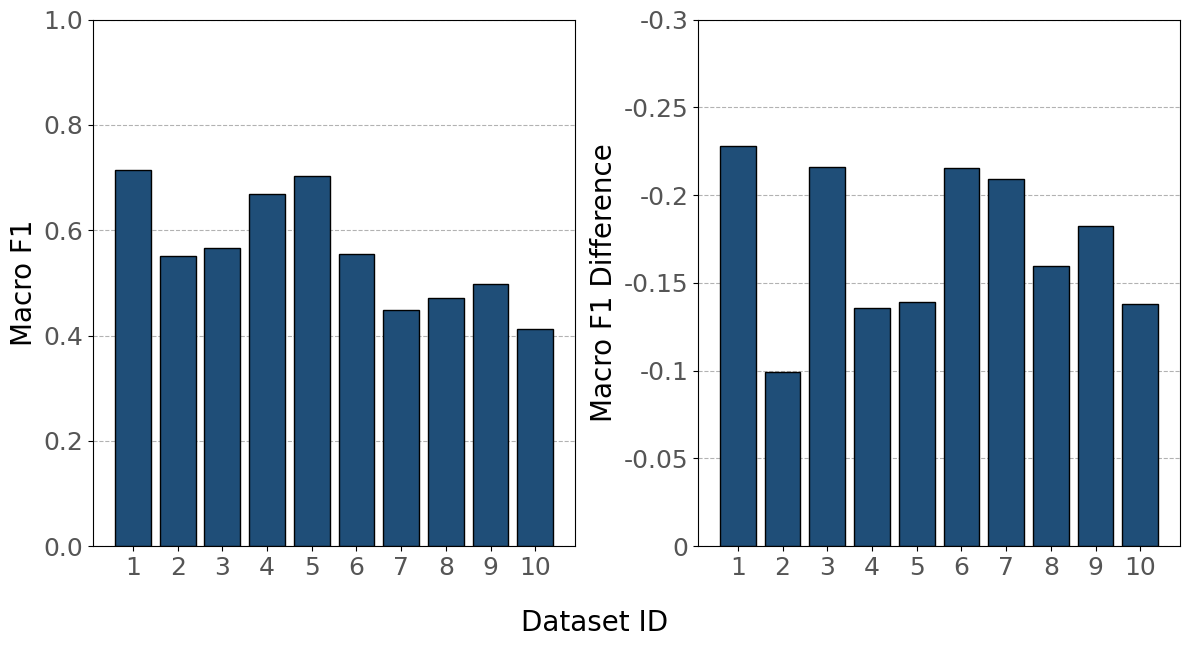

Saved combined histogram to /data/private/BreizhCrops/experiments/training_results/results/histogram_plots/Baseline_Histograms.svg
Overall_Accuracy - Lowest value: 0.5022, Highest value: 0.7880
Macro_F1 - Lowest value: 0.4118, Highest value: 0.7147
Macro_F1_Difference - Lowest value: -0.2277, Highest value: -0.0991


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the directory for saving histograms
histogram_plots_directory = '/data/private/BreizhCrops/experiments/training_results/results/histogram_plots'
os.makedirs(histogram_plots_directory, exist_ok=True)

# Read the baseline results CSV
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Function to create histograms for the baseline model
def create_histogram(ax, metric, ylabel, adjust_ticks=False):
    # Filter the dataframe for the baseline model
    baseline_df = df[df['Method'] == 'baseline']
    
    # Plot histogram
    color = '#1f4e78'  # Dark blue color
    if adjust_ticks:
        # Plot the bars as positive values
        ax.bar(baseline_df['Dataset_ID'], -baseline_df[metric], color=color, edgecolor='black', alpha=1, zorder=3)
        # Set y-ticks for a range from 0 to 0.3 but display as negative values
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
        ax.set_yticklabels(['0', '-0.05', '-0.1', '-0.15', '-0.2', '-0.25', '-0.3'])
    else:
        ax.bar(baseline_df['Dataset_ID'], baseline_df[metric], color=color, edgecolor='black', alpha=1, zorder=3)
        # Set y-ticks for metrics from 0 to 1
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xticks(baseline_df['Dataset_ID'])  # Ensure all dataset IDs are shown
    
    ax.tick_params(axis='both', which='major', labelcolor='#555555', labelsize=18)
    
    ax.grid(axis='y', linestyle='--', alpha=0.6, color='grey', zorder=0)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create histogram for "Macro F1"
create_histogram(
    ax=axes[0],
    metric='Macro_F1',
    ylabel='Macro F1'
)

# Create histogram for "Macro F1 Difference" (Plot as positive and override ticks)
create_histogram(
    ax=axes[1],
    metric='Macro_F1_Difference',
    ylabel='Macro F1 Difference',
    adjust_ticks=True  # Adjust ticks to show as negative
)

# Add a single common x-axis label
fig.text(0.5, -0.06, 'Dataset ID', ha='center', fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()

# Save the combined plot
plot_path = os.path.join(histogram_plots_directory, 'Baseline_Histograms.svg')
plt.savefig(plot_path, format='svg', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved combined histogram to {plot_path}")

# Calculate and print lowest and highest values for each metric
metrics = ['Overall_Accuracy', 'Macro_F1', 'Macro_F1_Difference']
baseline_df = df[df['Method'] == 'baseline']  # Filter for baseline

for metric in metrics:
    lowest_value = baseline_df[metric].min()
    highest_value = baseline_df[metric].max()
    print(f'{metric} - Lowest value: {lowest_value:.4f}, Highest value: {highest_value:.4f}')


/tmp/ipykernel_450/2919394630.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['Complexity'] = baseline_df['Dataset_ID'].map(dataset_complexity)
/tmp/ipykernel_450/2919394630.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['ID'] = baseline_df['Dataset_ID'].map(dataset_imbalance)
/tmp/ipykernel_450/2919394630.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

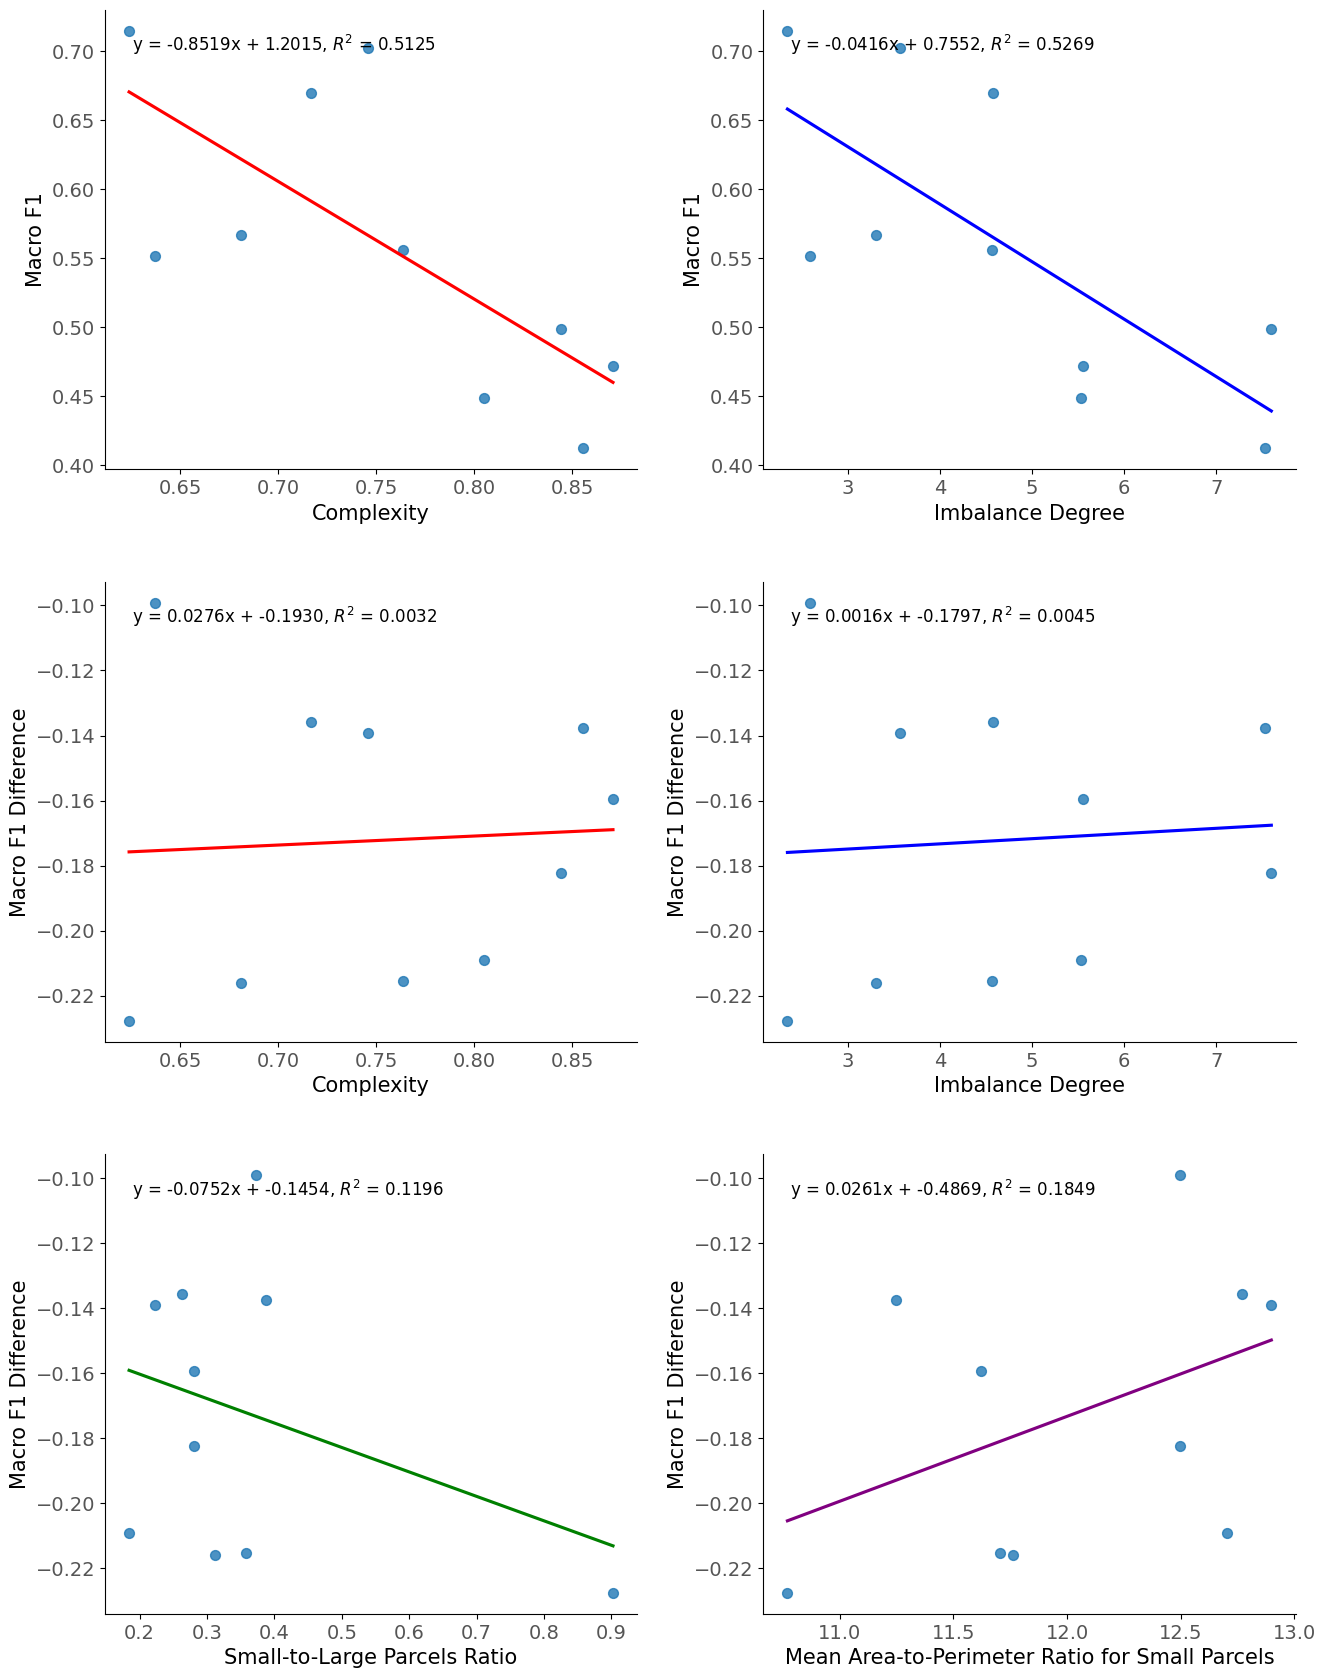

Saved combined plot to /data/private/BreizhCrops/experiments/training_results/results/combined_plots/Baseline_Metrics_vs_Complexity_Imbalance_and_Ratios.svg


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set the directory for saving combined plots
combined_plots_directory = '/data/private/BreizhCrops/experiments/training_results/results/combined_plots'
os.makedirs(combined_plots_directory, exist_ok=True)

# Read the baseline results CSV
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Read the summary training datasets CSV to get additional metrics
summary_csv = '/data/private/BreizhCrops/experiments/undersampled_csvs/main/summary_training_datasets.csv'
summary_df = pd.read_csv(summary_csv)

# Extract dataset IDs and their relevant values
dataset_complexity = summary_df.set_index('id')['complexity'].to_dict()
dataset_imbalance = summary_df.set_index('id')['ID'].to_dict()
small_to_large_ratio = summary_df.set_index('id')['small-to-large-area-ratio'].to_dict()
mean_area_to_perimeter_ratio = summary_df.set_index('id')['mean_ratio_small'].to_dict()

# Filter for the baseline model
baseline_df = df[df['Method'] == 'baseline']

# Merge the baseline data with complexity, imbalance, and thinness metrics
baseline_df['Complexity'] = baseline_df['Dataset_ID'].map(dataset_complexity)
baseline_df['ID'] = baseline_df['Dataset_ID'].map(dataset_imbalance)
baseline_df['Small_to_Large_Ratio'] = baseline_df['Dataset_ID'].map(small_to_large_ratio)
baseline_df['Mean_Area_to_Perimeter_Ratio'] = baseline_df['Dataset_ID'].map(mean_area_to_perimeter_ratio)

# Define metrics and plot parameters (excluding 'Overall Accuracy')
metrics = [
    ('Macro_F1', 'Macro F1'),
    ('Macro_F1_Difference', 'Macro F1 Difference')
]

# Set up the combined plot with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.tight_layout(pad=6.0)

def create_scatter_with_regression(ax, x, y, xlabel, ylabel, color):
    sns.regplot(x=x, y=y, data=baseline_df, ax=ax, ci=None, 
                scatter_kws={'s': 50}, line_kws={'color': color})
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    # Fit a linear regression line and display the equation
    X = baseline_df[[x]]
    y_data = baseline_df[y]
    model = LinearRegression().fit(X, y_data)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y_data)
    
    # Make plot more open by hiding unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis='both', which='major', labelcolor='#555555', labelsize=14)

    # Display the equation and R-squared in one line and adjust position
    ax.text(x=0.05, y=0.95, 
            s=f'y = {slope:.4f}x + {intercept:.4f}, $R^2$ = {r_squared:.4f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Plot Complexity vs each metric (only 2 metrics)
for i, (metric, ylabel) in enumerate(metrics):
    create_scatter_with_regression(
        ax=axes[i, 0], 
        x='Complexity', 
        y=metric, 
        xlabel='Complexity', 
        ylabel=ylabel, 
        color='red'
    )

# Plot Imbalance Degree (ID) vs each metric (only 2 metrics)
for i, (metric, ylabel) in enumerate(metrics):
    create_scatter_with_regression(
        ax=axes[i, 1], 
        x='ID', 
        y=metric, 
        xlabel='Imbalance Degree', 
        ylabel=ylabel, 
        color='blue'
    )

# Add new plots for the last row
# Plot Small-to-Large Area Ratio vs Macro F1 Difference
create_scatter_with_regression(
    ax=axes[2, 0], 
    x='Small_to_Large_Ratio', 
    y='Macro_F1_Difference', 
    xlabel='Small-to-Large Parcels Ratio', 
    ylabel='Macro F1 Difference', 
    color='green'
)

# Plot Mean Area to Perimeter Ratio (Small Parcels) vs Macro F1 Difference
create_scatter_with_regression(
    ax=axes[2, 1], 
    x='Mean_Area_to_Perimeter_Ratio', 
    y='Macro_F1_Difference', 
    xlabel='Mean Area-to-Perimeter Ratio for Small Parcels', 
    ylabel='Macro F1 Difference', 
    color='purple'
)

# Save the combined plot
plot_path = os.path.join(combined_plots_directory, 'Baseline_Metrics_vs_Complexity_Imbalance_and_Ratios.svg')
plt.savefig(plot_path, format='svg', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved combined plot to {plot_path}")


In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Read the baseline results CSV
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Read the summary training datasets CSV to get additional metrics
summary_csv = '/data/private/BreizhCrops/experiments/undersampled_csvs/main/summary_training_datasets.csv'
summary_df = pd.read_csv(summary_csv)

# Extract relevant metrics from the summary
small_to_large_ratio = summary_df.set_index('id')['small-to-large-area-ratio'].to_dict()
mean_area_to_perimeter_ratio = summary_df.set_index('id')['mean_ratio_small'].to_dict()

# Filter for the baseline model
baseline_df = df[df['Method'] == 'baseline']

# Merge the baseline data with additional metrics
baseline_df['Small_to_Large_Ratio'] = baseline_df['Dataset_ID'].map(small_to_large_ratio)
baseline_df['Mean_Area_to_Perimeter_Ratio'] = baseline_df['Dataset_ID'].map(mean_area_to_perimeter_ratio)

# Define the dependent variable (Macro F1 Difference)
y = baseline_df['Macro_F1_Difference']

# Define the independent variables (Small-to-Large Area Ratio and Mean Area-to-Perimeter Ratio)
X = baseline_df[['Small_to_Large_Ratio', 'Mean_Area_to_Perimeter_Ratio']]

# Perform multiple linear regression
model = LinearRegression().fit(X, y)

# Get the R² value for the combined characteristics
r_squared = model.score(X, y)
print(f'R² for combined Small-to-Large Area Ratio and Mean Area-to-Perimeter Ratio on Macro F1 Difference: {r_squared:.4f}')

# Get coefficients for each predictor
coefficients = model.coef_
intercept = model.intercept_
print(f'Coefficients: Small-to-Large Area Ratio = {coefficients[0]:.4f}, Mean Area-to-Perimeter Ratio = {coefficients[1]:.4f}')
print(f'Intercept: {intercept:.4f}')


R² for combined Small-to-Large Area Ratio and Mean Area-to-Perimeter Ratio on Macro F1 Difference: 0.1859
Coefficients: Small-to-Large Area Ratio = -0.0106, Mean Area-to-Perimeter Ratio = 0.0239
Intercept: -0.4561


/tmp/ipykernel_450/1641493216.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['Small_to_Large_Ratio'] = baseline_df['Dataset_ID'].map(small_to_large_ratio)
/tmp/ipykernel_450/1641493216.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['Mean_Area_to_Perimeter_Ratio'] = baseline_df['Dataset_ID'].map(mean_area_to_perimeter_ratio)


/tmp/ipykernel_455/2225730431.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['Classes'] = baseline_df['Dataset_ID'].map(dataset_classes)


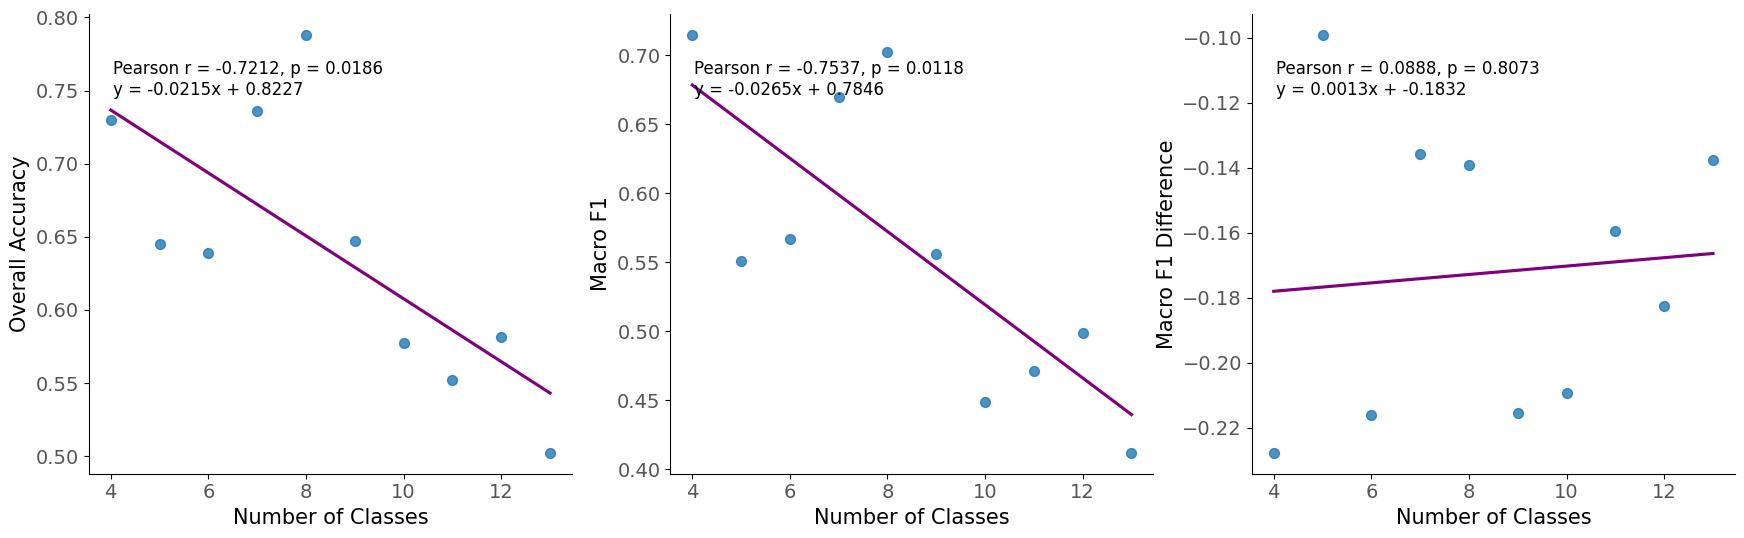

Saved correlation plot to /data/private/BreizhCrops/experiments/training_results/results/correlation_plots/Classes_vs_Metrics_Correlation.svg

Pearson Correlation Results:
Metric: Overall_Accuracy, Pearson r: -0.7212, p-value: 0.0186
Metric: Macro_F1, Pearson r: -0.7537, p-value: 0.0118
Metric: Macro_F1_Difference, Pearson r: 0.0888, p-value: 0.8073


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# Set the directory for saving plots
correlation_plots_directory = '/data/private/BreizhCrops/experiments/training_results/results/correlation_plots'
os.makedirs(correlation_plots_directory, exist_ok=True)

# Read the baseline results CSV
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Read the summary training datasets CSV to get additional values
summary_csv = '/data/private/BreizhCrops/experiments/undersampled_csvs/main/summary_training_datasets.csv'
summary_df = pd.read_csv(summary_csv)

# Extract dataset IDs and their number of classes
dataset_classes = summary_df.set_index('id')['classes'].to_dict()

# Filter for the baseline model
baseline_df = df[df['Method'] == 'baseline']

# Merge the baseline data with number of classes
baseline_df['Classes'] = baseline_df['Dataset_ID'].map(dataset_classes)

# Define metrics and plot parameters
metrics = [
    ('Overall_Accuracy', 'Overall Accuracy'),
    ('Macro_F1', 'Macro F1'),
    ('Macro_F1_Difference', 'Macro F1 Difference')
]

# Initialize a list to store correlation results
correlation_results = []

# Set up the combined plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.tight_layout(pad=4.0)

for i, (metric, ylabel) in enumerate(metrics):
    # Calculate Pearson correlation
    X = baseline_df['Classes']
    y = baseline_df[metric]
    corr_coeff, p_value = pearsonr(X, y)
    correlation_results.append((metric, corr_coeff, p_value))
    
    # Scatter plot with a regression line
    sns.regplot(x='Classes', y=metric, data=baseline_df, ax=axes[i], ci=None, 
                scatter_kws={'s': 50}, line_kws={'color': 'purple'})
    axes[i].set_xlabel('Number of Classes', fontsize=15)
    axes[i].set_ylabel(ylabel, fontsize=15)
    
    # Fit a linear regression line and display the equation
    model = LinearRegression().fit(X.values.reshape(-1, 1), y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X.values.reshape(-1, 1), y)
    
    # Display the correlation coefficient and equation
    axes[i].text(x=0.05, y=0.9, 
                 s=f'Pearson r = {corr_coeff:.4f}, p = {p_value:.4f}\ny = {slope:.4f}x + {intercept:.4f}', 
                 transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    # Make plot more open by hiding unnecessary spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].tick_params(axis='both', which='major', labelcolor='#555555', labelsize=14)

# Save the plot
plot_path = os.path.join(correlation_plots_directory, 'Classes_vs_Metrics_Correlation.svg')
plt.savefig(plot_path, format='svg', bbox_inches='tight')
plt.show()
plt.close()
print(f"Saved correlation plot to {plot_path}")

# Print the correlation results
print("\nPearson Correlation Results:")
for metric, corr_coeff, p_value in correlation_results:
    print(f"Metric: {metric}, Pearson r: {corr_coeff:.4f}, p-value: {p_value:.4f}")


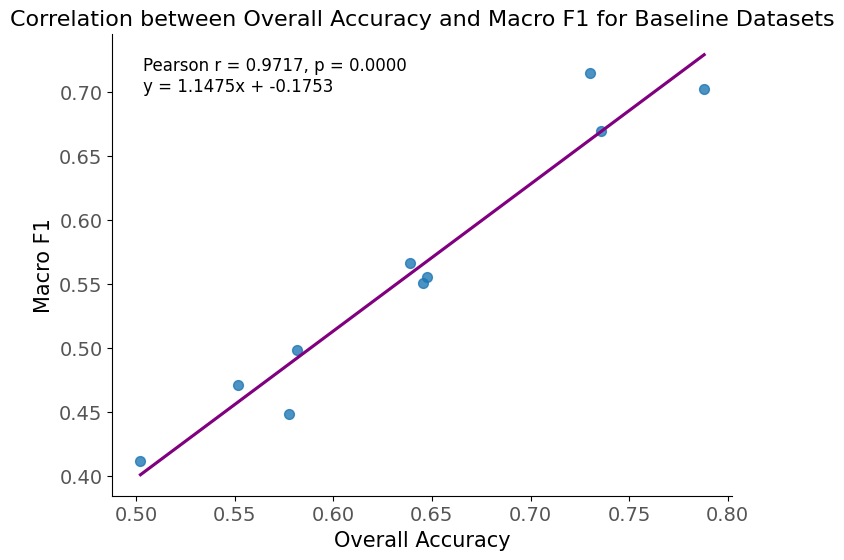

Saved correlation plot to /data/private/BreizhCrops/experiments/training_results/results/correlation_plots/OA_vs_Macro_F1_Correlation.svg

Pearson Correlation between Overall Accuracy and Macro F1:
Pearson r: 0.9717, p-value: 0.0000


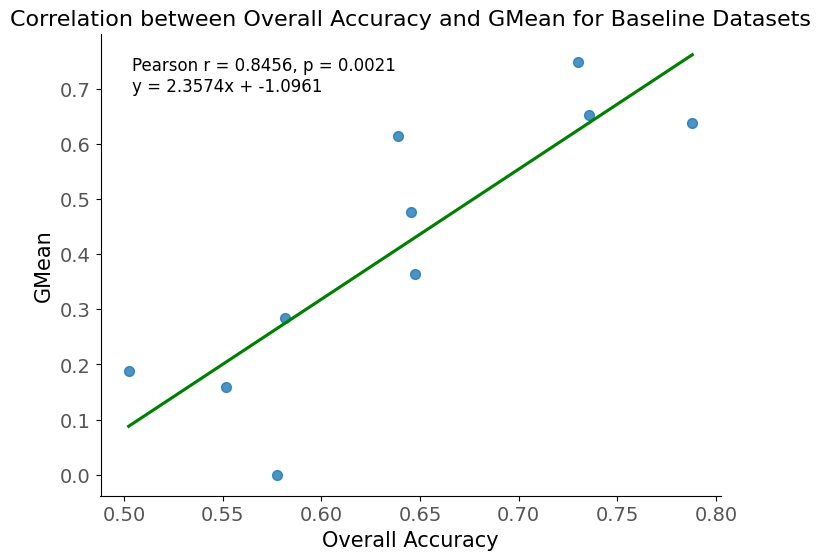

Saved correlation plot to /data/private/BreizhCrops/experiments/training_results/results/correlation_plots/OA_vs_GMean_Correlation.svg

Pearson Correlation between Overall Accuracy and GMean:
Pearson r: 0.8456, p-value: 0.0021


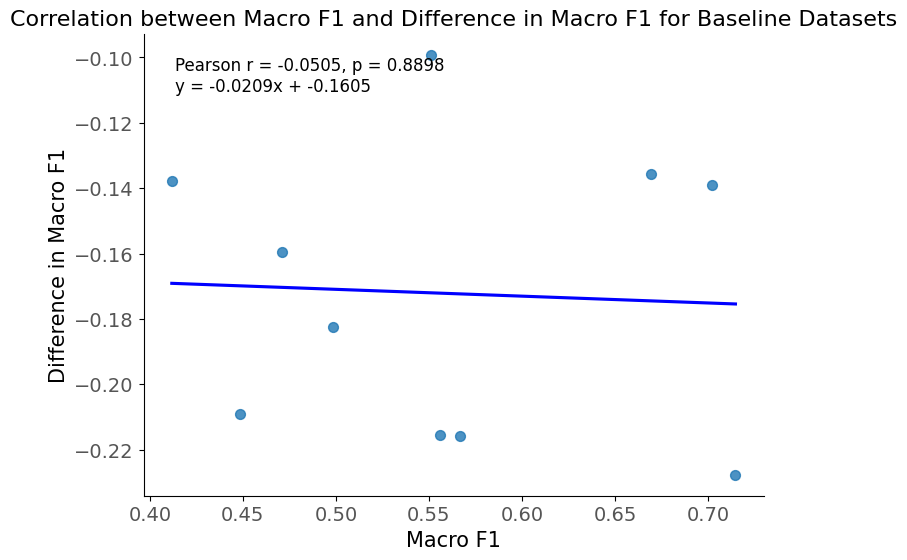

Saved correlation plot to /data/private/BreizhCrops/experiments/training_results/results/correlation_plots/Macro_F1_vs_Diff_Correlation.svg

Pearson Correlation between Macro F1 and Difference in Macro F1:
Pearson r: -0.0505, p-value: 0.8898


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Set the directory for saving plots
correlation_plots_directory = '/data/private/BreizhCrops/experiments/training_results/results/correlation_plots'
os.makedirs(correlation_plots_directory, exist_ok=True)

# Read the baseline results CSV
results_csv = '/data/private/BreizhCrops/experiments/training_results/results/results.csv'
df = pd.read_csv(results_csv)

# Filter for the baseline model
baseline_df = df[df['Method'] == 'baseline']

def plot_and_calculate_correlation(x_metric, y_metric, xlabel, ylabel, plot_color, filename):
    X = baseline_df[x_metric]
    y = baseline_df[y_metric]

    # Calculate Pearson correlation
    corr_coeff, p_value = pearsonr(X, y)

    # Set up the plot
    plt.figure(figsize=(8, 6))

    # Scatter plot with regression line
    sns.regplot(x=x_metric, y=y_metric, data=baseline_df, ci=None, 
                scatter_kws={'s': 50}, line_kws={'color': plot_color})

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(f'Correlation between {xlabel} and {ylabel} for Baseline Datasets', fontsize=16)

    # Fit a linear regression line and display the equation
    model = LinearRegression().fit(X.values.reshape(-1, 1), y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X.values.reshape(-1, 1), y)

    # Display the correlation coefficient and equation on the plot
    plt.text(x=0.05, y=0.95, 
             s=f'Pearson r = {corr_coeff:.4f}, p = {p_value:.4f}\ny = {slope:.4f}x + {intercept:.4f}', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Make plot more open by hiding unnecessary spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tick_params(axis='both', which='major', labelcolor='#555555', labelsize=14)

    # Save the plot
    plot_path = os.path.join(correlation_plots_directory, filename)
    plt.savefig(plot_path, format='svg', bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved correlation plot to {plot_path}")

    # Print the correlation results
    print(f"\nPearson Correlation between {xlabel} and {ylabel}:")
    print(f"Pearson r: {corr_coeff:.4f}, p-value: {p_value:.4f}")

# Plot and calculate correlation for "Overall Accuracy" vs "Macro F1"
plot_and_calculate_correlation(
    x_metric='Overall_Accuracy',
    y_metric='Macro_F1',
    xlabel='Overall Accuracy',
    ylabel='Macro F1',
    plot_color='purple',
    filename='OA_vs_Macro_F1_Correlation.svg'
)

# Plot and calculate correlation for "Overall Accuracy" vs "GMean"
plot_and_calculate_correlation(
    x_metric='Overall_Accuracy',
    y_metric='GMean',  # Ensure "GMean" is a column in your dataset
    xlabel='Overall Accuracy',
    ylabel='GMean',
    plot_color='green',
    filename='OA_vs_GMean_Correlation.svg'
)

# Plot and calculate correlation for "Macro F1" vs "Difference in Macro F1"
plot_and_calculate_correlation(
    x_metric='Macro_F1',
    y_metric='Macro_F1_Difference',
    xlabel='Macro F1',
    ylabel='Difference in Macro F1',
    plot_color='blue',
    filename='Macro_F1_vs_Diff_Correlation.svg'
)
